# Dunnhumby: The Complete Journey

Nathaniel Poland

February 2022


# Demographics

*In this notebook we'll take a look at the `hh_demographic.csv` table; demographic information for 801 of the 2500 household answers collected by user survey*


## Customer Focus

The project as a whole is based around understanding the purchase behaviour of customers of the grocery chain. We would be happy to have some sort of **customer profile**, which offers context to any findings regarding the purchase behaviour of any given `household_key`.


### Bias of our sample data; is it representative of the underlying population?

We recognize an **inherent sampling bias** to the information found in this table; we might assume that we only have demographic information from those who opted to take the survey, but we can't be sure what the selection process was for these households. Also, this **data was generated and entered by human input**.


### Demographics or Transactions?

It makes sense to have a customer profile based on how households **interacted with our stores through transactions**; but we should definitely do our due diligence about any information that's available.

Moreover, If we can synthesize **any viable target features**, we might be able to train a model on this data which can take a guess or predict about that feature for our other households, thereby informing recommendations later.

There's a brief business summary below, and below that is my walkthrough for `hh_demographic.csv`.

# Business Summary/tl;dr


INPUTS/OBSERVATIONS:
- 32% of 2500 total households are represented by the 801 `household_key`s in this data.
**This represents 56% of total revenue in the `transaction_data.csv` file, a significant percentage.**  

- Sample Bias & Confusing Questions
    - Unknown values in marital status, homeowner status, kid status
- Households vary in size (number of members), potentially distorting our analysis
- Despite potentially representing distinct members of a household, we have a singular value for both the age and income columns; these have many potential values with poorly distributed classes.
    - distribution of age groups is primarily the working class and older;
    - significant number of married households as well as unknown values 
    - distribution of income groups suggests that median income is ~50K
    
OUTPUTS:
Structured 5 binary labels with even distributions;

- `age_45+`, 

- `income_50K+`, 

- `single`, 

- `couple`, 

- `family` 

And one categorical column;

-`single_couple_family`

As well as providing all transformations to form categorical variable columns with more raw mappings.

Imports
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']==(16,6)
import my_funcs

plt.rcParams['figure.figsize']=(16,6)
plt.style.use('seaborn')

In [ ]:
import seaborn as sns

In [5]:
# my_funcs.load_demo().head(1)

# Exploring the Data

In [3]:
demo = pd.read_csv('data/hh_demographic.csv')

In [4]:
print(demo.info())
demo.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   AGE_DESC             801 non-null    object
 1   MARITAL_STATUS_CODE  801 non-null    object
 2   INCOME_DESC          801 non-null    object
 3   HOMEOWNER_DESC       801 non-null    object
 4   HH_COMP_DESC         801 non-null    object
 5   HOUSEHOLD_SIZE_DESC  801 non-null    object
 6   KID_CATEGORY_DESC    801 non-null    object
 7   household_key        801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB
None


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8


The table consists of 801 rows of demographic information, each for a unique `household_key`. The data is in 'object' format; strings.

In [19]:
### There are 8 columns in the table. Below are the skeleton value counts:

# for col in demo:
#     print(demo[col].value_counts())

Further below we will plot this information in a more readable way.

Summary of Columns:
---
`AGE_DESC`
Good descriptive information, if arbitrary; but poorly balanced classes.

`MARITAL_STATUS_CODE`

    A = married
    B = single
    U = unknown

`INCOME_DESC` Many distinct values, including with income ranges 100K+; perhaps due to double income.

`HOMEOWNER_DESC`
Around 1/4 unknown values. 

`HH_COMP_DESC`
Household composition description; again, poorly balanced classes.

`HOUSEHOLD_SIZE_DESC`
Ranging from 1-5+.

`KID_CATEGORY_DESC`
Almost 3/4 unknown/None values.

`household_key`
Unique Identifier for each household

In [7]:
demo.household_key.duplicated().sum()
# no duplicate household_keys

0

## Applying categorical columns ranks with the pd.Categorical object

In [11]:
demo['AGE_DESC'] = pd.Categorical(demo['AGE_DESC'], ['19-24', '25-34','35-44',  '45-54', '55-64',  '65+',])

demo['MARITAL_STATUS_CODE'] = pd.Categorical(demo['MARITAL_STATUS_CODE'].map({'A':'Married', 'B':'Single', 'U': 'Unknown'}), ['Married', 'Single', 'Unknown'])

demo['INCOME_DESC']= pd.Categorical(demo['INCOME_DESC'], ['Under 15K','15-24K','25-34K', '35-49K', '50-74K','75-99K',  
       '100-124K', '125-149K', '150-174K', '175-199K', '200-249K','250K+', ])

demo['HOMEOWNER_DESC']= pd.Categorical(demo['HOMEOWNER_DESC'], ['Homeowner', 'Unknown', 'Renter', 'Probable Renter', 'Probable Owner'], ordered=False)

demo['HH_COMP_DESC']=pd.Categorical(demo['HH_COMP_DESC'], ['Unknown', 'Single Female', 'Single Male', '1 Adult Kids','2 Adults No Kids', '2 Adults Kids'], ordered=False)
demo['HOUSEHOLD_SIZE_DESC'] = pd.Categorical(demo['HOUSEHOLD_SIZE_DESC'], ['1', '2','3','4','5+',])
demo['KID_CATEGORY_DESC']=pd.Categorical(demo['KID_CATEGORY_DESC'], ['None/Unknown', '1','2','3+',])

## Plotting Class Distributions for Demographics

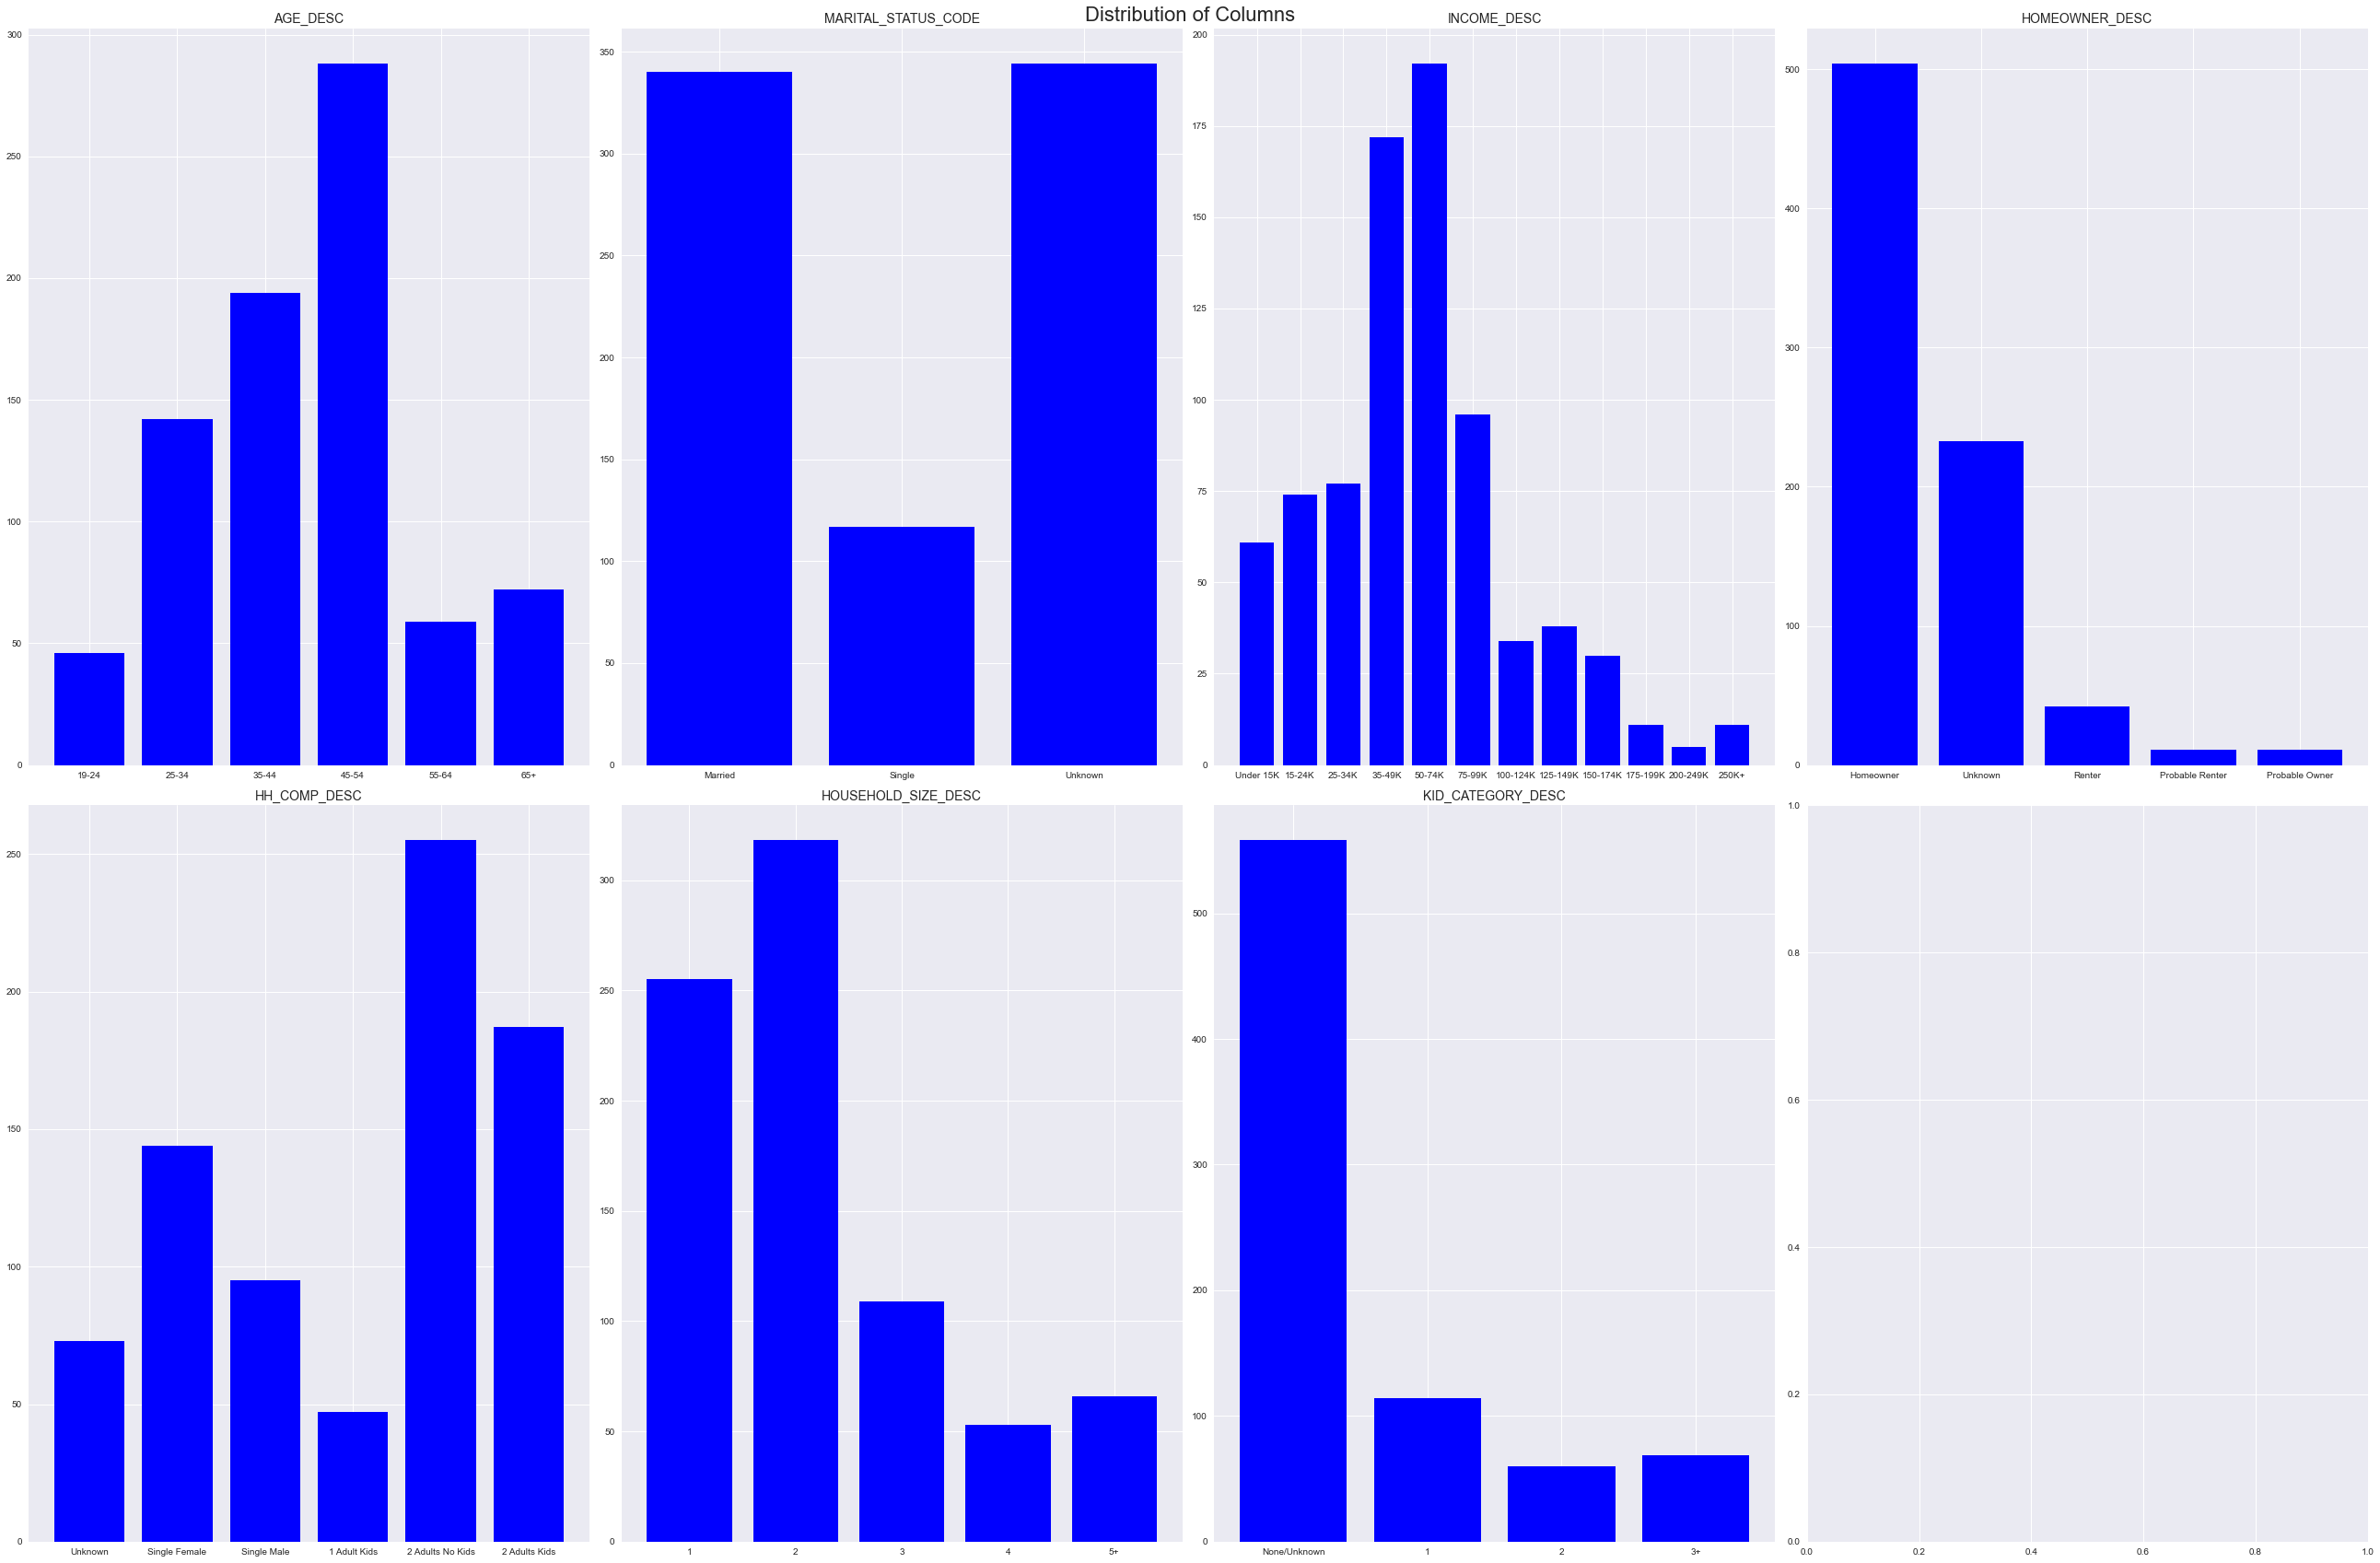

In [17]:
columns = 4
rows = (len(demo.columns)-1)//columns + 1
plt.subplots(rows, columns, figsize=(36, 24))
plt.suptitle('Distribution of Columns', size=22)
for idx, col in enumerate(demo.drop('household_key', axis=1).columns):
    data = dict(demo[col].value_counts())
    order = list(demo[col].cat.categories)
    plt.subplot(rows, columns, idx+1)
    plt.title(f'{col}', size=14)

    for x in order:
        plt.bar(x, data[x], color='blue')
    
plt.tight_layout()
plt.show()

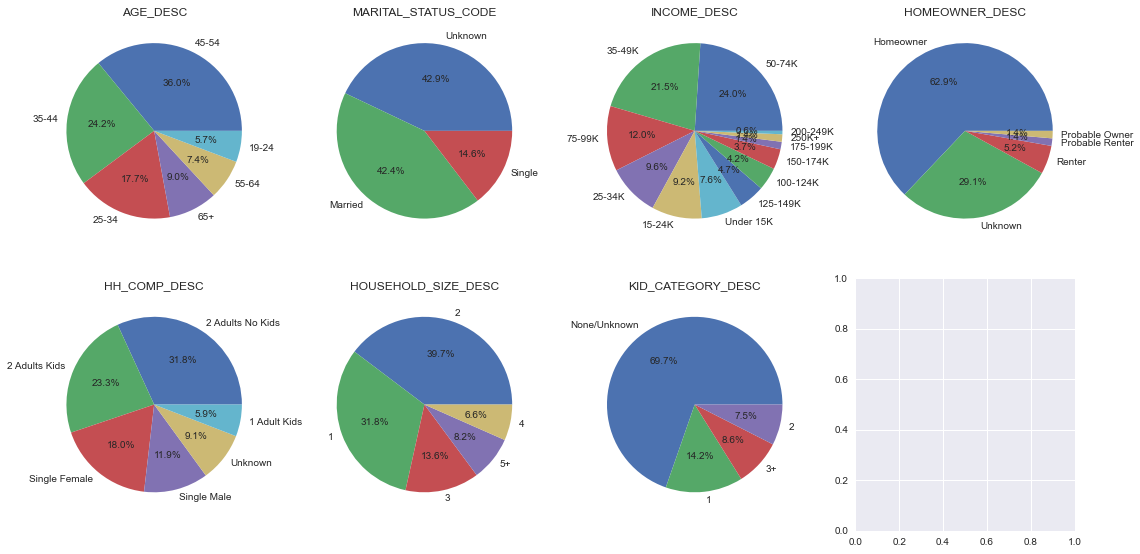

In [14]:
my_funcs.plot_pies(demo.drop('household_key', axis=1))

Briefly examining Sales Value of households for which we have demographic information:
---

In [8]:
# import the transactions table for a basic reference 
transactions = pd.read_csv('data/transaction_data.csv')

In [21]:
# list of household_keys in hh_demographic
demo_hh = demo['household_key'].values

demo_sales = transactions[transactions['household_key'].isin(demo_hh)]['SALES_VALUE'].sum()

non_demo_sales = transactions[~transactions['household_key'].isin(demo_hh)]['SALES_VALUE'].sum()

total_sales = demo_sales + non_demo_sales

print(f'{demo_sales} is the total sales value of households with demographic information listed.')
print(f'{non_demo_sales} is the total sales value of households not listed in hh_demographic.')
print()
print(f'{total_sales} is the total sales value across all households.')
print()
print(f'{round((demo_sales/total_sales) * 100,2)}% is the percentage of sales accounted for\nby households for which we have demographic information.')
print()
print(f'{round((non_demo_sales/total_sales) * 100,2)}% is the percentage of sales accounted for\nby households for which we do not have demographic information.')

3861807.6100000003 is the total sales value of households with demographic information listed.
3063324.13 is the total sales value of households not listed in hh_demographic.

6925131.74 is the total sales value across all households.

55.77% is the percentage of sales accounted for
by households for which we have demographic information.

44.23% is the percentage of sales accounted for
by households for which we do not have demographic information.


Total Sales Impressions
---

**Despite making up only 32% of our households, the customers for which we have demographic information account for ~56% of the total sales in the data** (This is consistent even after the data cleaning which happens in the following notebooks).

We knew that the customers in our data were all purportedly **frequent shoppers** at our grocery chain, making market segmentation more difficult in some senses. However, this subset of customers is valuable; within the context of our data, and likely outside it. 

**We should be cautious about extrapolating any analysis or interpretations onto customers of the grocery chain as a whole**.

### `HOUSEHOLD_SIZE_DESC`

Each household has a varying number of members, as given in `HOUSEHOLD_SIZE_DESC`; be them children or adults. This will almost certainly impact the sales total for each household, as well as the products they might want to receive advertisements for.

We might imagine that **households with more members will require more food and other goods**; that families (or larger households) have the potential to be our best customers. For example, individuals or couples might be at an inherent 'disadvantage' in terms of aggregate sales comparisons with households of 5+; in terms of monetary value or even frequency of purchases, **larger households might spend more, more often**. 

# Column Observations

**`AGE_DESC`**

- The households in our survey are leaning significantly towards the elderly age groups. **More than half the households for which we have demographic info report an age of 45+** I'd be particularly interested in how to distinguish couples from families in the 45-54 age group, as a tendency which younger 'families' *might* trend towards -- thereby 'helping' the model to predict younger families with higher recall.

**`HOMEOWNER_DESC`** 

- According to this data, **more than 63% of the households for which we have demographic info likely own homes**.

**`HOUSEHOLD_SIZE_DESC`** 
- Seems to be the most complete and informative column about our household sizes here -- what I might guess is the most relevant factor with respect to comparisons with an RFM score. 
- **No NaN or Unknown values**

**`HH_COMP_DESC`** 

- Creates some definition and variance in the data -- guided by someone with more experience, I might consider delving in here. 
    - **'Unknown' values makes up 9% of the column**.
    - We could drop the 9% of rows, or impute their values somehow, based on a swag-y guess using the household size desc. 
    - Taking it one step further, we could examine sales patterns for the households, to add a second decision boundary.
- It seemingly separates Single male and female individuals -- as well as single-parent households with kids, which might be a point of confusion. 


**`KID_CATEGORY_DESC`** 

- Combined, **None and Unknown labels make up more than 2/3 of the column**
- 31.3% of the households 'have kids' confirmed; compared with 28.4% of households in the 'HH_COMP_DESC' of size 3 or greater. 

Using the recommender system class shown later in the project, we could examine households in these various categories and promote advertising based on their most recent purchases.

## Summary of Potential Data Cleaning and Transformations
---

None of the transformations below are executed by the cells; they print the 'value counts'.

In [90]:
# AGE_DESC
demo['AGE_DESC'].map(
{
'19-24':"0-34",
'25-34':"0-34",
"35-44":"35-44",
'45-54':"45+",
'55-64':"45+",
'65+':"45+",
}).value_counts()
# Splitting 45+ results in a much smaller fourth class, adding another class imbalance.
# At least the other two categories are similar in size? 
# Are the two smaller classes the most 'variant'? in terms of their within-label spending, for our purposes??

45+      419
35-44    194
0-34     188
Name: AGE_DESC, dtype: int64

In [91]:
# MARITAL_STATUS_CODE
demo['MARITAL_STATUS_CODE'].value_counts()

# .map({'Married':1,
#       'Single':2,
#      'Unknown':0}).value_counts()

Unknown    344
Married    340
Single     117
Name: MARITAL_STATUS_CODE, dtype: int64

In [92]:
# INCOME_DESC
demo['INCOME_DESC'].map({'Under 15K': '0-49K',
 '175-199K': '100K+',
 '35-49K': '0-49K',
 '125-149K': '100K+',
 '150-174K': '100K+',
 '15-24K': '0-49K',
 '50-74K': '50-99K',
 '250K+': '100K+',
 '200-249K': '100K+',
 '100-124K': '100K+',
 '75-99K': '50-99K',
 '25-34K': '0-49K'}).value_counts()

0-49K     384
50-99K    288
100K+     129
Name: INCOME_DESC, dtype: int64

This column might easily misinform or bias our sales analysis.

In [37]:
demo['INCOME_DESC'].map({
                            'Under 15K': 0,
                             '15-24K': 0,
                             '25-34K': 0,
                             '35-49K': 0,
                             '50-74K': 1,
                             '75-99K': 1,
                             '100-124K': 1,
                             '125-149K': 1,
                             '150-174K': 1,                   
                             '175-199K': 1,  
                             '200-249K': 1,
                             '250K+': 1,
                            }).sum()

417

In [ ]:
# HOMEOWNER_DESC
demo['HOMEOWNER_DESC'].map({
"Homeowner":1,    
"Unknown":0,     
"Renter":0,     
"Probable Renter":0,     
"Probable Owner":1,        
}).value_counts()

In [94]:
# HH_COMP_DESC -- consider dropping Unknown values?
demo['HH_COMP_DESC'].value_counts()

2 Adults No Kids    255
2 Adults Kids       187
Single Female       144
Single Male          95
Unknown              73
1 Adult Kids         47
Name: HH_COMP_DESC, dtype: int64

In [95]:
# HOUSEHOLD_SIZE_DESC series to type int; note we are changing 5+ to 5... (losing information here)
demo['HOUSEHOLD_SIZE_DESC'].map({'1':1, '2':2, '3':3, '4':4, '5+':5}).astype(int).value_counts()

2    318
1    255
3    109
5     66
4     53
Name: HOUSEHOLD_SIZE_DESC, dtype: int64

## KID_CATEGORY_DESC -- dropping column 

In [ ]:
# demo.drop('KID_CATEGORY_DESC', axis=1)

# Thoughts about feature engineering / class distributions / customer profile labels

## `single_couple_family`

In [ ]:
demo['single_couple_family'] = demo['HOUSEHOLD_SIZE_DESC'].map({'1':1, '2':2, '3':3,'4':3,'5+':3})
demo['single_couple_family'] = pd.Categorical(demo['single_couple_family'], 
                                         [1,2,3,])

## `single`

In [1]:
demo['single'] =  np.where((demo['HH_COMP_DESC'] == 'Single Female') |
                               (demo['HH_COMP_DESC'] == 'Single Male') |
                               (demo['HOUSEHOLD_SIZE_DESC'] == '1'),
                                1, 0)

NameError: name 'demo' is not defined

## `couple`

In [ ]:
demo['couple'] =  np.where((demo['HH_COMP_DESC'] == '2 Adults no Kids'),
                                1, 0)

## `has_kids`

*Engineering a map for households with confirmed children*

In [41]:
# has_kids
demo['has_kids'] = np.where((demo['HH_COMP_DESC'] == '1 Adult Kids') |
                           (demo['HH_COMP_DESC'] == '2 Adults Kids') |
                            (demo['HOUSEHOLD_SIZE_DESC'].isin(['3', '4', '5+'])),
                            1, 0)

demo['has_kids'].value_counts()

0    559
1    242
Name: has_kids, dtype: int64

Using the queries below we can confirm that:

all entries labeled '1 Adult Kids' are now tagged appropriately as 'has_kids'

In [39]:
# demo[demo['HH_COMP_DESC']=='1 Adult Kids']

all entries labeled as '2 Adults No Kids' are appropriately NOT tagged as 'has_kids;'

In [43]:
# demo[demo['HH_COMP_DESC'] == '2 Adults No Kids']['has_kids'].sum()

## `age_45+`

I might be setting this boundary arbitrarily based on the class distributions of my test set.

In [32]:
# 
demo['AGE_DESC'].map(
{
'19-24':0,
'25-34':0,
"35-44":0,
'45-54':1,
'55-64':1,
'65+':1,
}).value_counts()


1    419
0    382
Name: AGE_DESC, dtype: int64

# Thoughts on Modelling/Customer Demographic Labels

We can come back to this (cleaned) demographic information later -- once we've cleaned the transaction data. With more information about our demographic households, we might even be able to 'project' or predict these values onto the other households in our data sales data by reference. Using cross-validation to train a model on different sections of our demographic households at a time could be effective.

## plot_categorical_column with `merged_demo`

This output `merged_demo` is formed by populating the outputs folder using the ETL() function.

In [31]:
merged_demo = pd.read_csv('data/outputs/merged_demo.csv', parse_dates=['datetime'], index_col=0) # merged, but for households in demo

C:\Users\polan\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [33]:
def plot_categorical_column(demo, 
                            merged,
                            mean=True,
                            resample_rule='BM',
                            sales_col='SALES_VALUE',
                            label_col='HOUSEHOLD_SIZE_DESC'):
    
    if mean==True:
        plt.title(f'Mean Sum of {sales_col} by {label_col}; over {resample_rule}')
    elif mean==False:
        plt.title(f'Sum of {sales_col} by {label_col}; over {resample_rule}')

    for size in demo[label_col].unique():
        hh_ids = list(demo[demo[label_col]==size]['household_key'])
        
        if mean==True: # divide by len(hh_ids)
            plt.plot((merged[merged['household_key'].isin(hh_ids)].resample(resample_rule,convention='end', on='datetime')['SALES_VALUE'].sum()/len(hh_ids)), label=f'{size}')
        else:
            plt.plot(merged[merged['household_key'].isin(hh_ids)].resample(resample_rule,convention='end', on='datetime')['SALES_VALUE'].sum(), label=f'{size}')

    
    plt.legend()

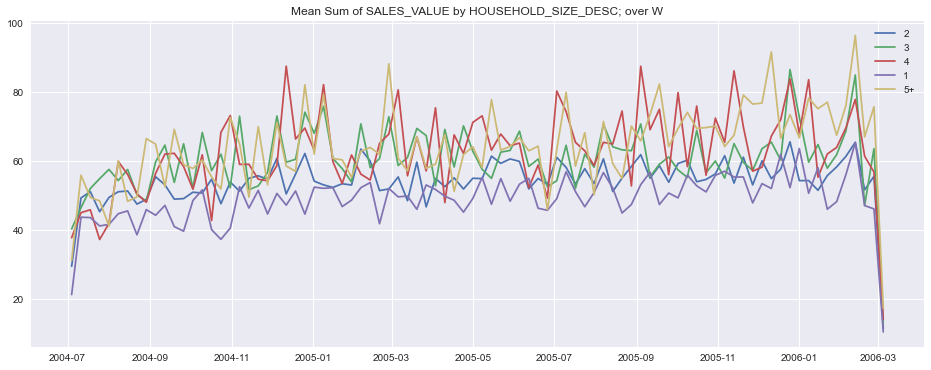

In [34]:
plt.figure(figsize=(16,6))
plot_categorical_column(demo, merged_demo, resample_rule='W')

Interesting that single and couple households seem to have more stable sales numbers, by the look of this weekly chart. If we pull it up again, this time as a monthly;

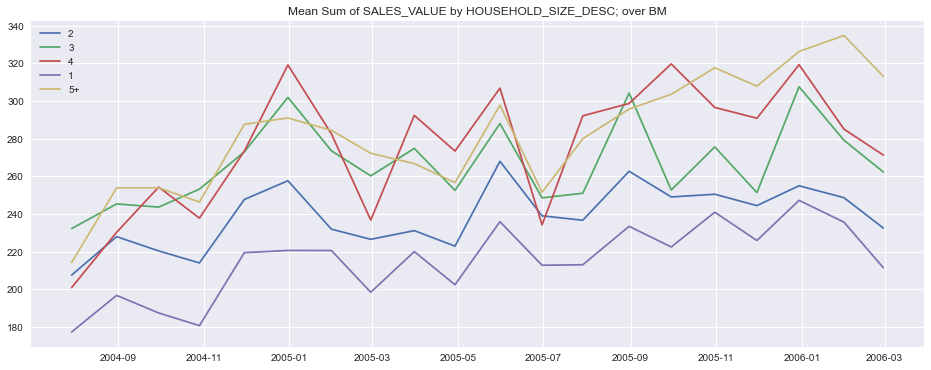

In [35]:
plt.figure(figsize=(16,6))
plot_categorical_column(demo, merged, resample_rule='BM')

- We can see that households with more members definitely seem to be purchasing more than our 2-member households, and they themselves more than our 1 member households.

- There is a seemingly significant downtick in revenue across all household size categories in March and again in July 2005. Households of size 3 and 5+ appear to be least affected.

- We have a seemingly significant increase in the spending by households of size 5+ from that point on. However, if we look at the total sum of sales:

In [ ]:
plt.figure(figsize=(16,6))
plot_categorical_column(demo, merged, mean=False)

In [ ]:
We see that since the households with children are broken into three groups, the uptick isn't quite as noticeable. We'll examine the trend of the data in subsequent notebooks.

In [ ]:
# Going back to that downtick, let's briefly glance at our advertising campaigns to see if we can identify a correlation; a #campaign ending perhaps. Another theory could be that the price of a key item or series of items was increased at this time.

# my_funcs.make_date_map(merged, 'DAY')

# my_funcs.load_campaign_summary(merged) ## TODO: this should load datetime values!!!

# Campaigns 8 and 9 ended on or near day 460; the 25th of June, 2005.

In [ ]:
hue='INCOME_DESC'
data = merged[merged['household_key'].isin(demo)]

In [ ]:
### `AGE_DESC & INCOME_DESC`

In [ ]:
Despite potentially having multiple members in a household, we have only a single value for `AGE_DESC` and `INCOME_DESC`; we can't be sure whether the respondent of the survey has entered their own income, or the total income of their household.

I would argue that the age description column gives us information about the breadwinners of the household (if they are similar in age) more so than it deceives us, and is therefore still a viable column for examining patterns, for example among individuals; couples; or families.

The information contained in the columns `HH_COMP_DESC`, `MARITAL_STATUS_CODE`, and `KID_CATEGORY_DESC` have inter-correlated or multi-collinear data, and might confuse any sales regression models about the feature importance of each. 

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,6))
plt.subplot(2,1,1)
plot_categorical_column(demo, merged, label_col='AGE_DESC',)
plt.subplot(2,1,2)
plot_categorical_column(demo, merged, mean=False, label_col='AGE_DESC',)
plt.tight_layout()
plt.show()

In [ ]:
Going from 5 to 6 labels makes the plots more difficult to interpret. In the second plot we can see that households in the 34-44, as well as the 45-54 age ranges are our biggest nominal spenders. Per capita, it is the 35-44 age range that has the highest mean sum of sales. 

Slump from January through march 2005 except for youngest group; uptick across non-middle aged categories in April 2005, across all categories June 2005; and again for most categories in September 2005. We'll have to take a look again after we remove seasonality and trend from the data. 

In [ ]:
# Sales Plots by Income Group

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,6))
plt.subplot(2,1,1)
plot_categorical_column(demo, merged, label_col='INCOME_DESC',)
plt.subplot(2,1,2)
plot_categorical_column(demo, merged, mean=False, label_col='INCOME_DESC',)
plt.tight_layout()
plt.show()

In [ ]:
This column is going to need some cleaning before we can effectively visualize the groups.

In [ ]:
demo['INCOME_DESC'] = demo['INCOME_DESC'].map({'Under 15K': '0-49K',
 '175-199K': '100K+',
 '35-49K': '0-49K',
 '125-149K': '100K+',
 '150-174K': '100K+',
 '15-24K': '0-49K',
 '50-74K': '50-99K',
 '250K+': '100K+',
 '200-249K': '100K+',
 '100-124K': '100K+',
 '75-99K': '50-99K',
 '25-34K': '0-49K'})

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,6))
plt.subplot(2,1,1)
plot_categorical_column(demo, merged, label_col='INCOME_DESC',)
plt.subplot(2,1,2)
plot_categorical_column(demo, merged, mean=False, label_col='INCOME_DESC',)
plt.tight_layout()
plt.show()

In [ ]:
We see that while customers from our highest income bracket have the highest mean sum of sales; this group is actually the smallest contributor to total revenue when compared with middle and low income brackets. The lowest income bracket takes the top spot in terms of total revenue (over time).

In [ ]:
demo.columns

In [ ]:
hh_agg = pd.read_csv('data/outputs/hh_agg.csv', index_col=0)



sns.pairplot(data=hh_agg[['avg_basket_spend', 'total_spend']],hue=demo_ss['INCOME_DESC'])

# WIP

In [ ]:
# Pull in transactions and check the total spend; avg basket spend; frequency of households by size desc.

In [19]:
merged = pd.read_csv('outputs/merged.csv')

In [21]:
merged.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,datetime,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC
0,2319,28179463886,101,909714,1,0.79,427,0.0,119,15,0.0,0.0,2004-07-01 01:19:00,2,PRODUCE,National,APPLES,APPLES GRANNY SMITH (BULK&BAG)
1,243,28197355878,102,909714,1,0.72,323,0.0,1011,15,0.0,0.0,2004-07-02 10:11:00,2,PRODUCE,National,APPLES,APPLES GRANNY SMITH (BULK&BAG)
2,707,28210545743,103,909714,1,2.35,429,0.0,1119,15,0.0,0.0,2004-07-03 11:19:00,2,PRODUCE,National,APPLES,APPLES GRANNY SMITH (BULK&BAG)
3,329,28210628714,103,909714,1,2.10,450,0.0,2037,15,0.0,0.0,2004-07-03 20:37:00,2,PRODUCE,National,APPLES,APPLES GRANNY SMITH (BULK&BAG)
4,1029,28210676830,103,909714,1,0.81,329,0.0,1148,15,0.0,0.0,2004-07-03 11:48:00,2,PRODUCE,National,APPLES,APPLES GRANNY SMITH (BULK&BAG)


In [54]:
demo['HOUSEHOLD_SIZE_DESC'] = demo['HOUSEHOLD_SIZE_DESC'].map({'1':1,'2':2,'3':3,'4':3,'5':3,'5+':3}).astype(int)

In [50]:
demo['HOUSEHOLD_SIZE_DESC'] = demo['HOUSEHOLD_SIZE_DESC'].map({1:1,2:2,3:3,4:3, 5:3})

In [48]:
df['SALES_VALUE'].sum()/len(df)

3.047089855072464

In [78]:
df['SALES_VALUE'].sum()/df['BASKET_ID'].nunique()

28.260013393432068

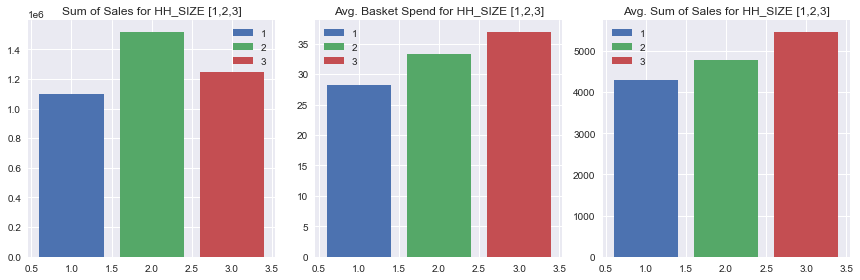

In [130]:
plt.subplots(1,3,figsize=(12,4))
plt.subplot(1,3,1)
plt.title('Sum of Sales for HH_SIZE [1,2,3]')
for idx, i in enumerate([1, 2, 3]):
    house_list = list(demo[demo['HOUSEHOLD_SIZE_DESC']==i]['household_key'])
    df = merged[merged['household_key'].isin(house_list)]
    plt.bar(i, df['SALES_VALUE'].sum(), label=f'{i}')
plt.legend()
plt.subplot(1,3,2)
plt.title('Avg. Basket Spend for HH_SIZE [1,2,3]')
for idx, i in enumerate([1, 2, 3]):
    house_list = list(demo[demo['HOUSEHOLD_SIZE_DESC']==i]['household_key'])
    df = merged[merged['household_key'].isin(house_list)]
    plt.bar(i, df['SALES_VALUE'].sum()/df['BASKET_ID'].nunique(), label=f'{i} ')

plt.legend()
plt.subplot(1,3,3)
plt.title('Avg. Sum of Sales for HH_SIZE [1,2,3]')
for idx, i in enumerate([1, 2, 3]):
    house_list = list(demo[demo['HOUSEHOLD_SIZE_DESC']==i]['household_key'])
    df = merged[merged['household_key'].isin(house_list)]
    plt.bar(i, df['SALES_VALUE'].sum()/df['household_key'].nunique(), label=f'{i} ')
plt.legend()

plt.tight_layout()
plt.show()    

In [94]:
house_list = list(demo[demo['HOUSEHOLD_SIZE_DESC']==1]['household_key'])
df = merged[merged['household_key'].isin(house_list)]

In [117]:
import warnings
warnings.filterwarnings('ignore')

NameError: name 'merged' is not defined

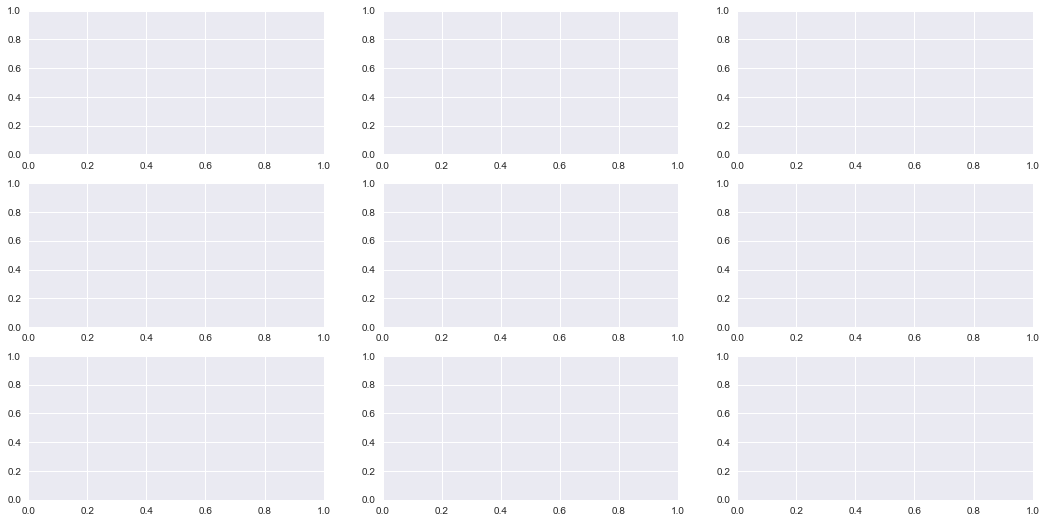

In [17]:
plt.subplots(3,3,figsize=(18,9), sharex='row')
# for each group
for idx, i in enumerate([1, 2, 3]):
    house_list = list(demo[demo['HOUSEHOLD_SIZE_DESC']==i]['household_key'])
    df = merged[merged['household_key'].isin(house_list)]
    
    # total sales for each household in the group
    plt.subplot(3,3,idx+1) 
    plt.title(f'Sum of Sales by household for HH_SIZE={i}')
    sns.boxenplot(df.groupby('household_key')['SALES_VALUE'].sum())
     
    # avg basket sum
    plt.subplot(3,3,idx+4)
    plt.title(f'Avg. Basket Spend for HH_SIZE{i}')
    sns.boxenplot(df.groupby('BASKET_ID')['SALES_VALUE'].sum()/df['BASKET_ID'].nunique())
    
    # avg. household sales
    plt.subplot(3,3,idx+7)
    plt.title(f'Avg. Household Spend for HH_SIZE{i}')
    sns.boxenplot(df.groupby('household_key')['SALES_VALUE'].sum()/df['household_key'].nunique())
    

plt.tight_layout()
plt.show()

This means that over the transactions by households for which we have demographic data, which represent ~56% of our sales revenue; almost \$4m;
- demographics comprising 1 person had the lowest sum of sales overall (but still over $1m)
- households comprising 2 people had the highest sum of sales overall
- The avg. basket spend and avg. sum of sales for households 